In [1]:
import os
import obspy.signal
from obspy import read
import copy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.std import trange

# Create raw monitoring data file
### save the filtered waveforms, corresponding source location, reference station location of each microearthquake, and event waveform log data into the npz file (raw monitoring data file)

In [3]:
def waveGenerater(wave_ini, waveLen):
    waveOutput = np.zeros([waveLen])
    iniLen = wave_ini.shape[0]
    if iniLen >= waveLen:
        waveOutput[50:waveLen-50] = wave_ini[50:waveLen-50]
        waveOutput[0:50] = wave_ini[50:100]
        waveOutput[waveLen-50:waveLen] = wave_ini[waveLen-100:waveLen-50]
    else:
        addLen = waveLen - iniLen
        waveOutput = np.zeros([waveLen])
        k = min(300+iniLen, waveLen)
#         print(k)
        waveOutput[300+50:k] = wave_ini[50:k-300]
    return waveOutput

In [16]:
NewberryData_path = r'SACFILES_12-13-selected'
event_file_list = os.listdir(NewberryData_path)
fileLen = len(event_file_list)
count = 0
evtDict = dict()
for root,dirs,files in os.walk(NewberryData_path):    # go through the folder
      for each in files:
             count += 1   # Count the number of files in the folder
# print (count//3, count%3)               # check file number
assert count%3 == 0, 'toltal sac file number is not correct, check the data'
waveLen = 4096
waveData = np.zeros([count//3, waveLen, 3])
labelIniData = np.zeros([count//3, 6])
evtScale = list()
badFilter_trace = list()
index = 0
freqList = list()
file_List = list()
for i in trange(fileLen):
    evtName = event_file_list[i]
    sacfile_path = NewberryData_path + '/' + str(evtName)
    sacfile_list = os.listdir(sacfile_path)
    sacNum = len(sacfile_list)
    evtScale.append([evtName, int(index)])
#     print(sacNum)
    assert sacNum%3 == 0, 'sac file number of this event is not correct, check the data'
    
    for j in range(sacNum//3):
        sacPerStation = np.zeros([waveLen, 3])
        kk = sacfile_list[j*3].split('.')
        k_tmp = str(kk[0]) + ':' + str(kk[1])
        file_List.append(k_tmp)
        sacfileRead_e = sacfile_path + '/' + str(sacfile_list[j*3])
        sacfileRead_n = sacfile_path + '/' + str(sacfile_list[j*3+1])
        sacfileRead_z = sacfile_path + '/' + str(sacfile_list[j*3+2])
        
        sacFileE = read(sacfileRead_e)[0]
        sacFileN = read(sacfileRead_n)[0]
        sacFileZ = read(sacfileRead_z)[0]
        freqList.append([i, j, sacFileE.stats.sampling_rate, sacFileN.stats.sampling_rate, sacFileZ.stats.sampling_rate])
        if sacFileE.stats.sampling_rate < 200:
            badFilter_trace.append([i, index, sacfile_list[j*3]])
        if sacFileN.stats.sampling_rate < 200:
            badFilter_trace.append([i, index, sacfile_list[j*3+1]])
        if sacFileZ.stats.sampling_rate < 200:
            badFilter_trace.append([i, index, sacfile_list[j*3+2]])
        
        if j==0:
            content = {'waveNumber': sacNum, 'evLat': sacFileE.stats.sac.evla, 'evLng': sacFileE.stats.sac.evlo, 'evDp': sacFileE.stats.sac.evdp}
            evtDict[evtName] = content
#         staName = sacFileE.stats.station
        streamEfilter = copy.deepcopy(sacFileE)
        streamNfilter = copy.deepcopy(sacFileN)
        streamZfilter = copy.deepcopy(sacFileZ)
        
#         waveform 0 correlation
        streamEfilter.data = streamEfilter.data - np.mean(streamEfilter.data)
        streamNfilter.data = streamNfilter.data - np.mean(streamNfilter.data)
        streamZfilter.data = streamZfilter.data - np.mean(streamZfilter.data)
        
#         staStreamFilter.filter('bandpass', freqmin=10, freqmax = 40, corners=8, zerophase=False)
        streamEfilter.filter('lowpass', freq=100, corners=4, zerophase=False)
        streamEfilter.decimate(factor=5, strict_length=False)
#         waveE = streamEfilter.data
        waveE = waveGenerater(streamEfilter.data, waveLen)
        
        streamNfilter.filter('lowpass', freq=100, corners=4, zerophase=False)
        streamNfilter.decimate(factor=5, strict_length=False)
#         waveN = streamNfilter.data
        waveN = waveGenerater(streamNfilter.data, waveLen)
        
        streamZfilter.filter('lowpass', freq=100, corners=4, zerophase=False)
        streamZfilter.decimate(factor=5, strict_length=False)
#         waveZ = streamZfilter.data
        waveZ = waveGenerater(streamZfilter.data, waveLen)
        
#         generate input data and initial label data
#         input data : after 0 centered
        waveE0center = waveE- np.mean(waveE[500:3500])
        waveN0center = waveN- np.mean(waveN[500:3500])
        waveZ0center = waveZ- np.mean(waveZ[500:3500])
        waveData[index,:,0] = waveE0center
        waveData[index,:,1] = waveN0center
        waveData[index,:,2] = waveZ0center

#         initial label data: first 3 columns are lat, lng, and depth of corresponding station; 4-6 columns are lat, lng, and depth of the source
        labelIniData[index,:] = np.array([sacFileE.stats.sac.evla, sacFileE.stats.sac.evlo, sacFileE.stats.sac.evdp, 
                                          sacFileE.stats.sac.stla, sacFileE.stats.sac.stlo, sacFileE.stats.sac.stel])
        
#         update row number
        index = index + 1

      

100%|██████████| 149/149 [00:24<00:00,  6.05it/s]


In [17]:
# print(waveData[0:1932,:,:].shape)
print(waveData.shape) 
print(labelIniData.shape, len(file_List))
sumArr = np.array([0, len(file_List)])
evtScale_arr = np.array(evtScale)
# evtScale_arr is a numpy array [earthquake number, waveform index] 
# the first column is the microearthquake number and the second column corresponds to the sequence number of the first waveform
evtScale_arr = np.vstack((evtScale_arr, sumArr))
# print(evtScale_arr)

(1877, 4096, 3)
(1877, 6) 1877


In [21]:
# save valid waveform data and corresponding initial label data (source location and reference station location) of each station and event waveform log data into a npz file
np.savez('rawDataNewBerry_0923', waveDataIni = waveData, labelDataIni = labelIniData, evtLog = evtScale_arr)
# waveData: 1877 valid 3-component waveform data (4096, 3) for 149 microearthquakes
# labelDataIni: initial data used for generate the label data with a dimention of 149 by 6, the first 3 columns denote the source coordinate and 4th-6th column are the reference station coordinate
# evtScale_arr: numpy array data with a dimention of 150 by 2

# create data pair data file
### select the pair of a source and 6 stations and their corresponding waveform to create station raw monitoring data file

In [11]:
import random
def generInput(waveIni, labelIni, indexRange, waveLen):
    rangeini, rangeterm = indexRange[0], indexRange[1]
    searchList = np.arange(rangeini, rangeterm) 
    if rangeterm - rangeini==7:
        inputGener = np.zeros([7, 6, waveLen, 3])
        positionGener = np.zeros([7, 6, 6])
        for j in range(7):
            iniSlice = waveIni[rangeini:rangeterm,:,:]
            useSlice = np.delete(iniSlice, j, axis=0)
            inputGener[j,:,:,:] = useSlice
            posIniSlice = labelIni[rangeini:rangeterm,:]
            posUseSlice = np.delete(posIniSlice, j, axis=0)
            positionGener[j,:,:] = posUseSlice
    else:
        iterNum = 20
        inputGener = np.zeros([iterNum, 6, waveLen, 3])
        positionGener = np.zeros([iterNum, 6, 6])
                for j in range(iterNum):
            selectIndex = random.sample(range(rangeini, rangeterm), 6)
            inputGener[j,:,:,:] = waveIni[selectIndex,:,:]
            positionGener[j,:,:] = labelIni[selectIndex,:]
    return inputGener, positionGener

In [33]:
filePath = 'rawDataNewBerry_0923.npz'
rawDataset = np.load(filePath)
fileList = rawDataset.files
rawWave = rawDataset[fileList[0]]
iniLabel = rawDataset[fileList[1]]
waveNumLog = rawDataset[fileList[2]]
print(rawWave.shape, iniLabel.shape, waveNumLog.shape)

(1877, 4096, 3) (1877, 6) (150, 2)


In [34]:
evtNum = waveNumLog.shape[0]-1
waveLen = rawWave.shape[1]
for i in trange(evtNum):
#     print(i)
    indexRange = [int(waveNumLog[i,1]), int(waveNumLog[i+1,1])]
    if i == 0:
        waveDataPair, positData = generInput(rawWave, iniLabel, indexRange, waveLen)
    else:
        waveDataPairTmp, positDataTmp = generInput(rawWave, iniLabel, indexRange, waveLen)
        waveDataPair = np.concatenate([waveDataPair, waveDataPairTmp], axis = 0)
        positData = np.concatenate([positData, positDataTmp], axis = 0)

100%|██████████| 149/149 [00:19<00:00,  7.46it/s]


In [35]:
print(waveDataPair.shape, positData.shape)

(2967, 6, 4096, 3) (2967, 6, 6)


### normalize station and source coordinate

In [36]:
# specify the scale
Escale = [43.67, 43.765]
Nscale = [-121.379, -121.22]
Zscale = [-1.5, 5.1]
Emin, Emax = Escale[0], Escale[1]
Nmin, Nmax = Nscale[0], Nscale[1]
Zmin, Zmax = Zscale[0], Zscale[1]
scaleData = np.array([Escale, Nscale, Zscale])
print(scaleData.shape)

(3, 2)


In [37]:
positData_nor = copy.deepcopy(positData)
Edata = positData_nor[:,:,[0,3]]
Ndata = positData_nor[:,:,[1,4]]
Zdata = positData_nor[:,:,[2,5]]
positData_nor[:,:,[0,3]] = (Edata-Emin)/(Emax-Emin)
positData_nor[:,:,[1,4]] = (Ndata-Nmin)/(Nmax-Nmin)
positData_nor[:,:,[2,5]] = (Zdata-Zmin)/(Zmax-Zmin)

In [38]:
np.savez('fieldDatapair0923.npz', waveIni = waveDataPair, positIniNor = positData_nor, scaleData = scaleData)

# create Input1, Input2, and Label for training
### generate Input1 (waveform data), Input2 (station layout data), and label data (vectors from reference station to the source) from data pair files

In [41]:
filePath = 'fieldDatapair0923.npz'
Dataset = np.load(filePath)
fileList = Dataset.files
waveInput = Dataset[fileList[0]]
positInput = Dataset[fileList[1]]
scaleData = Dataset[fileList[2]]
print(waveInput.shape, positInput.shape, scaleData.shape)

(2967, 6, 4096, 3) (2967, 6, 6) (3, 2)


In [42]:
assembleNum, staNum = waveInput.shape[0], waveInput.shape[1]
index = 0
checkpoint = dict()
for i in range(assembleNum):
    if index%100 == 0:
        print(index)
    for j in range(staNum):
        idCheck = i*staNum + j
        if index == 0:
            input1 = waveInput[i,:,:,:][np.newaxis,:,:,:]
            input2 = (positInput[i,:,3:6] - positInput[i,j,3:6])[np.newaxis,:,:]
            label = (positInput[i,j,0:3] - positInput[i,j,3:6])[np.newaxis,:]
#             onepoint = {'refr_station': positInput[i,j,3:6], 'source': positInput[i,j,0:3], 'stations': positInput[i,:,3:6]}
#             checkpoint[idCheck] = onepoint
        else:
            input1_tmp = waveInput[i,:,:,:][np.newaxis,:,:,:]
            input2_tmp = (positInput[i,:,3:6] - positInput[i,j,3:6])[np.newaxis,:,:]
            label_tmp = (positInput[i,j,0:3] - positInput[i,j,3:6])[np.newaxis,:]
#             onepoint = {'refr``station': positInput[i,j,3:6], 'source': positInput[i,j,0:3], 'stations': positInput[i,:,3:6]}
#             checkpoint[idCheck] = onepoint
            input1 = np.concatenate((input1, input1_tmp), axis = 0)
            input2 = np.concatenate((input2, input2_tmp), axis = 0)
            label = np.concatenate((label, label_tmp), axis = 0)
            del input1_tmp, input2_tmp, label_tmp
        index = index + 1

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800
8100
8400
8700
9000
9300
9600
9900
10200
10500
10800
11100
11400
11700
12000
12300
12600
12900
13200
13500
13800
14100
14400
14700
15000
15300
15600
15900
16200
16500
16800
17100
17400
17700


In [43]:
print(input1.shape, input2.shape, label.shape)

(17802, 6, 4096, 3) (17802, 6, 3) (17802, 3)


In [44]:
# wthis npz file consists of raw waveform data Input1 (not normalized), station layout data Input2 (normalized)
# , and label data Label (normalized)
np.savez('inputLabelNB0526.npz', Input1 = input1, Input2 = input2, Label = label)

### read station Info file and event catalog

In [10]:
staInfoPath = 'staInfo_df.csv'
staInfo_df = pd.read_csv(staInfoPath, index_col=0)
print(staInfo_df)

            lat         lon  depth
NM03  43.752331 -121.302223  1.866
NM06  43.724602 -121.300056  1.817
NM08  43.700851 -121.302887  1.841
NM22  43.725201 -121.308998  1.802
NM40  43.718311 -121.279640  1.968
NM41  43.710609 -121.291183  1.870
NM42  43.750580 -121.279167  2.011
NN07  43.751469 -121.325081  1.432
NN09  43.733158 -121.332558  1.421
NN17  43.720772 -121.327538  1.484
NN18  43.737560 -121.302132  1.592
NN19  43.718330 -121.306953  1.563
NN21  43.733189 -121.289864  1.694
NN24  43.732052 -121.308868  1.601
NN32  43.703850 -121.327499  1.395


In [7]:
catalogPath = 'D:/DL_location/NewBerryData/locations.csv'
evtCatalog = pd.read_csv(catalogPath)
print(evtCatalog)

      yr   jday  month  day  hour  minute     sec       lat        lon  depth  \
0    2012   303     10   29     8       2  21.363  43.72757 -121.30903  0.634   
1    2012   305     10   31     2      13   5.359  43.72702 -121.30970  1.005   
2    2012   305     10   31     3      58   1.335  43.72648 -121.30783  1.091   
3    2012   305     10   31    17      31  25.415  43.72662 -121.30878  1.227   
4    2012   306     11    1    11       7   8.782  43.72815 -121.31502 -1.500   
..    ...   ...    ...  ...   ...     ...     ...       ...        ...    ...   
485  2014   346     12   12     6      46  40.050  43.72272 -121.31493  0.919   
486  2014   346     12   12    10       6  31.869  43.72440 -121.31670  1.071   
487  2014   346     12   12    11       3  48.267  43.72397 -121.31313  0.589   
488  2014   348     12   14     8      41  11.443  43.71853 -121.31263  1.028   
489  2014   349     12   15     1      24  12.774  43.72220 -121.31117  0.746   

     magnitude        momen

In [8]:
# i = 49
print(evtCatalog.columns.values.tolist())
evtLog = pd.DataFrame(evtCatalog, columns = ['lat', 'lon', 'depth', 'magnitude'])
print(evtLog, evtLog.shape)

['yr ', 'jday', 'month', 'day', 'hour', 'minute', 'sec', 'lat', 'lon', 'depth', 'magnitude', 'moment', 'RMS', 'erh', 'erz', 'npicks', 'id', 'dbid']
          lat        lon  depth  magnitude
0    43.72757 -121.30903  0.634      0.384
1    43.72702 -121.30970  1.005      0.540
2    43.72648 -121.30783  1.091      0.430
3    43.72662 -121.30878  1.227      0.706
4    43.72815 -121.31502 -1.500      0.249
..        ...        ...    ...        ...
485  43.72272 -121.31493  0.919      0.404
486  43.72440 -121.31670  1.071      0.417
487  43.72397 -121.31313  0.589      0.041
488  43.71853 -121.31263  1.028      0.808
489  43.72220 -121.31117  0.746      0.149

[490 rows x 4 columns] (490, 4)


In [88]:
# print(staDict)
print(staDict.keys())
staD = dict()
for ii in staDict.keys():
    staD_comp0 = staDict[ii]['la']
    staD_comp1 = staDict[ii]['lo']
    staD_comp2 = staDict[ii]['el']
#     staD[ii]['la'] = set(staD[ii]['la'])
#     staD[ii]['lo'] = set(staD[ii]['lo'])
#     staD[ii]['el'] = set(staD[ii]['el'])
    staD[ii] = {'la':set(staD_comp0), 'lo':set(staD_comp1), 'el':set(staD_comp2)}
print(staD)

dict_keys(['NM03', 'NM06', 'NM08', 'NM22', 'NM40', 'NM41', 'NM42', 'NN07', 'NN09', 'NN17', 'NN18', 'NN19', 'NN21', 'NN24', 'NN32'])
{'NM03': {'la': {43.752331}, 'lo': {-121.30222}, 'el': {1.8660001}}, 'NM06': {'la': {43.724602}, 'lo': {-121.30006}, 'el': {1.817}}, 'NM08': {'la': {43.700851}, 'lo': {-121.30289}, 'el': {1.841}}, 'NM22': {'la': {43.725201}, 'lo': {-121.309}, 'el': {1.802}}, 'NM40': {'la': {43.718311}, 'lo': {-121.27964}, 'el': {1.9680001}}, 'NM41': {'la': {43.710609}, 'lo': {-121.29118}, 'el': {1.87}}, 'NM42': {'la': {43.75058}, 'lo': {-121.27917}, 'el': {2.0109999}}, 'NN07': {'la': {43.751469}, 'lo': {-121.32508}, 'el': {1.432}}, 'NN09': {'la': {43.733158}, 'lo': {-121.33256}, 'el': {1.421}}, 'NN17': {'la': {43.720772}, 'lo': {-121.32754}, 'el': {1.484}}, 'NN18': {'la': {43.73756}, 'lo': {-121.30213}, 'el': {1.592}}, 'NN19': {'la': {43.71833}, 'lo': {-121.30695}, 'el': {1.563}}, 'NN21': {'la': {43.733189}, 'lo': {-121.28986}, 'el': {1.694}}, 'NN24': {'la': {43.732052}, '

### plot station and microseismic data in the map


In [3]:
import sys
sys.path.insert(0,'folium')
import folium
import folium.plugins
from folium.features import *

class DivIcon(MacroElement):
    def __init__(self, html='', size=(30,30), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

In [17]:
# Create map and display it
latitude = 43.733189
longitude = -121.28986
NewBerry_map = folium.Map(location=[latitude, longitude], zoom_start=14,tiles='Stamen Terrain', prefer_canvas=True)

# Instantiate a feature group for the stations and microseismic events in the dataframe
stations = folium.map.FeatureGroup()
staNameList = staInfo_df._stat_axis.values.tolist()
msNameList = staInfo_df._stat_axis.values.tolist()
msevents = folium.map.FeatureGroup()



# Loop through the ms events data (evtLog) and add each event to the incidents feature group

# for j in range(evtLog.shape[0]):
for j in range(148):
    lat = evtLog['lat'][j]
    lng = evtLog['lon'][j]
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='red',
        fill=True,
        fill_color='orange',
        fill_opacity=0.8
    ).add_to(NewBerry_map)
    folium.map.Marker(
        [lat, lng],
        icon=DivIcon(
            size=(5,5),
            anchor=(5,0),
            html=str(j),
            style="""
                font-size:8px;
                background-color: transparent;
                border-color: transparent;
                text-align: right;
                """
            )
        ).add_to(NewBerry_map)
# Loop through the stations data (staInfo_df) and add each event to the incidents feature group
    
for i in range(staInfo_df.shape[0]):
    lat = staInfo_df['lat'][i]
    lng = staInfo_df['lon'][i]
#     stations.add_child(
    folium.CircleMarker(
        [lat, lng],
        radius=6, # define how big you want the circle markers to be
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(NewBerry_map)

    folium.map.Marker(
        [lat, lng],
        icon=DivIcon(
            size=(40,18),
            anchor=(10,0),
            html=staNameList[i],
            style="""
                font-size:18px;
                background-color: transparent;
                border-color: transparent;
                text-align: right;
                """
            )
        ).add_to(NewBerry_map)



#     folium.map.Marker(
#         [lat, lng],
#         icon=DivIcon(
#             size=(40,18),
#             anchor=(10,0),
#             html=staNemwList[i],
#             style="""
#                 font-size:18px;
#                 background-color: transparent;
#                 border-color: transparent;
#                 text-align: right;
#                 """
#             )
#         ).add_to(NewBerry_map)

# NewBerry_map.save('stations_and_ms_on_folium_map.html')
NewBerry_map

# Display the map of San Francisco
# san_map
# Add incidents to map
# NewBerry_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# NewBerry_map.add_child(stations)
# NewBerry_map.add_child(msevents)

### bad trace sample

         network: 7B
         station: NN32
        location: 00
         channel: e
       starttime: 2014-10-16T23:08:19.999999Z
         endtime: 2014-10-16T23:08:49.988001Z
   sampling_rate: 249.99998474121094
           delta: 0.00400000024414064
            npts: 7498
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.0040000002, 'depmin': -8.2332162e-06, 'depmax': 1.8940732e-07, 'b': -16.374001, 'stla': 43.70385, 'stlo': -121.3275, 'stel': 1.395, 'evla': 43.726734, 'evlo': -121.31067, 'evdp': 0.792, 'depmen': -1.1084827e-06, 'nzyear': 2014, 'nzjday': 289, 'nzhour': 23, 'nzmin': 8, 'nzsec': 36, 'nzmsec': 374, 'nvhdr': 6, 'npts': 7498, 'iftype': 1, 'leven': 1, 'kstnm': 'NN32', 'khole': '00', 'kcmpnm': 'e', 'knetwk': '7B'})


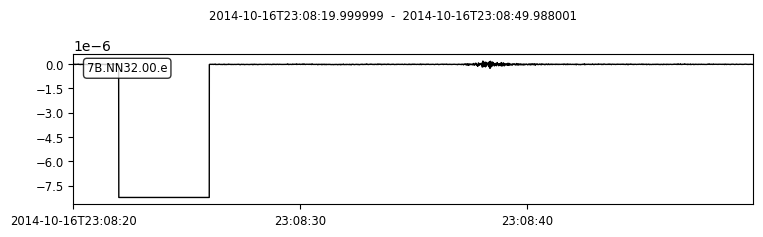

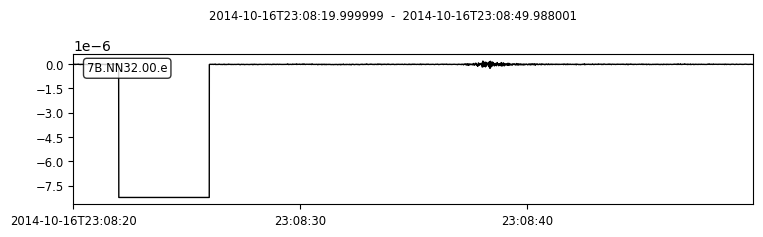

In [13]:
stream = read(r'D:\DL_location\NewBerryData\badtraces\141016230836.NN32.e')
st = stream[0]
print(st.stats)
st.plot()